In [303]:
import os
import sys
import math
import numpy as np
import numpy.linalg
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [304]:
def data_retrieval(sourcefile, metadata, pt_id):

	'''
	This function reads data for a single patient from a master spreadsheet with amplicon data for all plates/patients.
	Input is the sourcefile with the readcounts (allele_counts_anon), and a metadata file which contains cell type for each plate (Amplicon_metadata_fixed_anon.xlsx).
	The function returns a dataframe containing just the data for the specified patient, ready to merge with index data and then plot.
	'''

	df = pd.read_csv(sourcefile, header = [0,1,2], index_col = 0, sep='\t')
	df = df.stack([0,1,2])
	df = df.reorder_levels([1,0,2,3])
	df = df.to_frame()  #puts everything back in a dataframe
	df.columns = ['Reads']
	df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
	df['Well'] = df.index.get_level_values(1)
	df['Amplicon'] = df.index.get_level_values(2)
	df['Genotype'] = df.index.get_level_values(3)
	df[['Patient', 'one', 'two']] = df['Amplicon'].str.split('_', expand = True)
	df = df.drop(columns = ['one', 'two'])

	#Import information about plate cell type and patient
	key = pd.read_excel(metadata, sheet_name = 'PlateID') #should this be an input? also in next fucntion
	key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells'], axis=1)
	key.rename(columns = {'Comments2':'Plate'}, inplace = True)
	key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)

	#Make a dictionary to associate plates with patients and plate with cell type
	plate_pt_dict = dict(zip(key.Plate, key.Patient))
	plate_cell_dict = dict(zip(key.Plate, key.Celltype))

	#Now just look at data from selected patient, and apply filters to identify cells with enough reads/amplicon
	pt_allele_plate = df.loc[df['Patient'].isin([pt_id])] 
	pt_allele_plate = pt_allele_plate.drop(columns = 'Patient') #Drop the Patient ID column and other unwanted cols
	pt_allele_plate['Cell_type'] = pt_allele_plate['Plate'].replace(plate_cell_dict)
	pt_allele_plate['Plate_Well'] = pt_allele_plate['Plate'].astype(str) + '_' + pt_allele_plate['Well'].astype(str)

	return pt_allele_plate

In [305]:
def calc_scVAF(data, pt_init, reads):
    
    '''
    This function takes amplicon read counts for mt and wt and calculates the proportion of mutated alleles in each cell that meets the specified read count.
    '''
    
    cond = pt_init
    print(cond)
    
    if cond == 'JP001':  #cols is the columns actually being used, can be easily tweaked
        cols = ['JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a']
        #cols = ['JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a','JP001_TET2b_g']
        allcols = ['JP001_RUNX1_c','JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a','JP001_TET2b_c','JP001_TET2b_g']
    elif cond == 'PD7153':
        cols = ['PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b']
        allcols = ['PD7153_CUX1', 'PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b', 'PD7153_TGFB3_c', 'PD7153_TGFB3_g']
    elif cond == 'PD7151': 
        cols = ['PD7151_TET2a', 'PD7151_TET2b']
        allcols = ['PD7151_TET2a', 'PD7151_TET2b']
        
    else:
        print('Enter JP001,  PD7153, or PD7151 as pt_id')
    
    #Import information about plate cell type and patient
    key = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed_anon.xlsx', sheet_name = 'PlateID')
    key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells'], axis=1)
    key.rename(columns = {'Comments2':'Plate'}, inplace = True)
    key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)
    
    #Make a dictionary to associate plates with patients and plate with cell type
    plate_pt_dict = dict(zip(key.Plate, key.Patient))
    plate_cell_dict = dict(zip(key.Plate, key.Celltype))
    
    #Group the data and apply filters
    df = data.copy()
    df = df.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
    df.columns = allcols
    
    df = df.loc[(df[cols] >= reads).all(axis=1)] #df1 contains just the rows with cells we want - use this to create a filter or key
    df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
    df['Well'] = df.index.get_level_values(1)
    df['Plate_Well'] = df['Plate'].astype(str) + '_' + df['Well'].astype(str)
    wells = df['Plate_Well'].drop_duplicates().to_list() 
    print(f'Cells with {reads} reads  = ', len(wells))

    df2 = data.copy()
    df2 = df2[df2['Plate_Well'].isin(wells)]
    df2 = df2[df2['Amplicon'].isin(cols)]
    
    #Calculate the allele frequency
    df2 = df2.iloc[:, 0:1].unstack(level = 3)
    df2['Total'] = df2.iloc[: , 0] + df2.iloc[: , 1]
    df2['Mut_freq'] = df2.iloc[:, 0]/df2['Total']
    

    #Assign Wt or MT to each allele
    df2 = df2.drop(columns = ['Reads', 'Total'])
    df2 = df2.unstack(2)
    df2.columns = cols


    df2['Sort_cell_type'] = df2.index.get_level_values(0)
    df2['Sort_cell_type'] = df2['Sort_cell_type'].replace(plate_cell_dict)
    df2['Plate'] = df2.index.get_level_values(0)
    df2['Well'] = df2.index.get_level_values(1)
    df2['Plate_Well'] = df2['Plate'].astype(str) + '_' + df2['Well'].astype(str)
    df2 = df2.drop(columns = ['Plate', 'Well'])

    
    return df2

In [306]:
sourcefile = '../Data/Amp_data/allele_counts_anon.tsv'
metadata = '../Data/Amp_data/Amplicon_metadata_fixed_anon.xlsx'
pt_id = 'JP001'
plate = data_retrieval(sourcefile, metadata, pt_id)
reads = 50
plate2 = calc_scVAF(plate, pt_id, reads)
plate2

JP001
Cells with 50 reads  =  1234


JP001_RUNX1_g  JP001_SRSF2  JP001_TET2a Sort_cell_type  Plate_Well
AS-194 A12       0.007752     0.009259     0.000000           nBCs  AS-194_A12
       A13       0.000384     0.010638     0.000000           nBCs  AS-194_A13
       A16       0.006993     0.034591     0.014563           nBCs  AS-194_A16
       A18       0.000817     0.000000     0.000000           nBCs  AS-194_A18
       A19       0.000000     0.000000     0.001815           nBCs  AS-194_A19
...                   ...          ...          ...            ...         ...
AS-187 H24       0.613861     0.457447     0.837500      Monocytes  AS-187_H24
       I8        0.018182     0.652778     0.430108      Monocytes   AS-187_I8
       I14       0.000000     0.659574     0.029412      Monocytes  AS-187_I14
       L13       0.000648     0.960630     0.342857      Monocytes  AS-187_L13
       P23       0.396226     0.004972     0.000000      Monocytes  AS-187_P23

[1234 rows x 5 columns]

In [307]:
def calc_scVAF_binary_per_cell(data, pt_init, reads, cutoff):
    
    '''
    This function takes amplicon read counts for mt and wt and calculates whether a given cell does (1) or does not (0) contain a mutant allele, based on the desired read count and cutoff values.
    '''
    
    cond = pt_init
    print(cond)
    
    if cond == 'JP001':  #cols is the columns actually being used, can be easily tweaked
        cols = ['JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a']
        #cols = ['JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a','JP001_TET2b_g']
        allcols = ['JP001_RUNX1_c','JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a','JP001_TET2b_c','JP001_TET2b_g']
    elif cond == 'PD7153':
        cols = ['PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b']
        allcols = ['PD7153_CUX1', 'PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b', 'PD7153_TGFB3_c', 'PD7153_TGFB3_g']
    elif cond == 'PD7151': 
        cols = ['PD7151_TET2a', 'PD7151_TET2b']
        allcols = ['PD7151_TET2a', 'PD7151_TET2b']
        
    else:
        print('Enter JP001,  PD7153, or PD7151 as pt_id')
    
    #Import information about plate cell type and patient
    key = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed_anon.xlsx', sheet_name = 'PlateID')
    key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells'], axis=1)
    key.rename(columns = {'Comments2':'Plate'}, inplace = True)
    key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)
    
    #Make a dictionary to associate plates with patients and plate with cell type
    plate_pt_dict = dict(zip(key.Plate, key.Patient))
    plate_cell_dict = dict(zip(key.Plate, key.Celltype))
    
    #Group the data and apply filters
    df = data.copy()
    df = df.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
    df.columns = allcols
    
    df = df.loc[(df[cols] >= reads).all(axis=1)] #df1 contains just the rows with cells we want - use this to create a filter or key
    df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
    df['Well'] = df.index.get_level_values(1)
    df['Plate_Well'] = df['Plate'].astype(str) + '_' + df['Well'].astype(str)
    wells = df['Plate_Well'].drop_duplicates().to_list() 
    print(f'Cells with {reads} reads  = ', len(wells))

    df2 = data.copy()
    df2 = df2[df2['Plate_Well'].isin(wells)]
    df2 = df2[df2['Amplicon'].isin(cols)]
    
    #Calculate the allele frequency
    df2 = df2.iloc[:, 0:1].unstack(level = 3)
    df2['Total'] = df2.iloc[: , 0] + df2.iloc[: , 1]
    df2['Mut_freq'] = df2.iloc[:, 0]/df2['Total']
    
    #Assign Wt or MT to each allele
    df2 = df2.drop(columns = ['Reads', 'Total'])

    conditions = [(df2['Mut_freq'] <= cutoff), (df2['Mut_freq']) > cutoff ]
    values = [0, 1]
    df2['Genotype'] = np.select(conditions, values)
    df2 = df2.drop(columns = ['Mut_freq']).unstack(2)
    df2.columns = cols


    df2['Sort_cell_type'] = df2.index.get_level_values(0)
    df2['Sort_cell_type'] = df2['Sort_cell_type'].replace(plate_cell_dict)
    df2['Plate'] = df2.index.get_level_values(0)
    df2['Well'] = df2.index.get_level_values(1)
    df2['Plate_Well'] = df2['Plate'].astype(str) + '_' + df2['Well'].astype(str)
    df2 = df2.drop(columns = ['Plate', 'Well'])
    
    return df2

In [308]:
cutoff = 0.1
plate3 = calc_scVAF_binary_per_cell(plate, pt_id, reads, cutoff)
plate3

JP001
Cells with 50 reads  =  1234


JP001_RUNX1_g  JP001_SRSF2  JP001_TET2a Sort_cell_type  Plate_Well
AS-194 A12              0            0            0           nBCs  AS-194_A12
       A13              0            0            0           nBCs  AS-194_A13
       A16              0            0            0           nBCs  AS-194_A16
       A18              0            0            0           nBCs  AS-194_A18
       A19              0            0            0           nBCs  AS-194_A19
...                   ...          ...          ...            ...         ...
AS-187 H24              1            1            1      Monocytes  AS-187_H24
       I8               0            1            1      Monocytes   AS-187_I8
       I14              0            1            0      Monocytes  AS-187_I14
       L13              0            1            1      Monocytes  AS-187_L13
       P23              1            0            0      Monocytes  AS-187_P23

[1234 rows x 5 columns]

In [309]:
plate3['JP001_RUNX1_g'].value_counts()

0    1096
1     138
Name: JP001_RUNX1_g, dtype: int64

In [310]:
#Work out how to plot as VAF plots byt cell type
#Could also merge first with index celltype
plate2

JP001_RUNX1_g  JP001_SRSF2  JP001_TET2a Sort_cell_type  Plate_Well
AS-194 A12       0.007752     0.009259     0.000000           nBCs  AS-194_A12
       A13       0.000384     0.010638     0.000000           nBCs  AS-194_A13
       A16       0.006993     0.034591     0.014563           nBCs  AS-194_A16
       A18       0.000817     0.000000     0.000000           nBCs  AS-194_A18
       A19       0.000000     0.000000     0.001815           nBCs  AS-194_A19
...                   ...          ...          ...            ...         ...
AS-187 H24       0.613861     0.457447     0.837500      Monocytes  AS-187_H24
       I8        0.018182     0.652778     0.430108      Monocytes   AS-187_I8
       I14       0.000000     0.659574     0.029412      Monocytes  AS-187_I14
       L13       0.000648     0.960630     0.342857      Monocytes  AS-187_L13
       P23       0.396226     0.004972     0.000000      Monocytes  AS-187_P23

[1234 rows x 5 columns]

In [311]:
x = plate2.groupby(by = 'Sort_cell_type').mean()
x = x.unstack().to_frame()
x['celltype'] = x.index.get_level_values(1)
x['Amplicon'] = x.index.get_level_values(0)
co = ['VAF', 'sort_celltype', 'Amplicon']
x.columns = co
x.sort_values(by=['sort_celltype'], inplace = True)
x

,,VAF,sort_celltype,Amplicon
,Sort_cell_type,,,
JP001_RUNX1_g,CD34,0.046755,CD34,JP001_RUNX1_g
JP001_SRSF2,CD34,0.504555,CD34,JP001_SRSF2
JP001_TET2a,CD34,0.371449,CD34,JP001_TET2a
JP001_RUNX1_g,CD34+/38-,0.063946,CD34+/38-,JP001_RUNX1_g
JP001_SRSF2,CD34+/38-,0.486869,CD34+/38-,JP001_SRSF2
JP001_TET2a,CD34+/38-,0.419972,CD34+/38-,JP001_TET2a
JP001_RUNX1_g,Monocytes,0.110265,Monocytes,JP001_RUNX1_g
JP001_SRSF2,Monocytes,0.464549,Monocytes,JP001_SRSF2
JP001_TET2a,Monocytes,0.285876,Monocytes,JP001_TET2a


Text(0.5, 0, '')

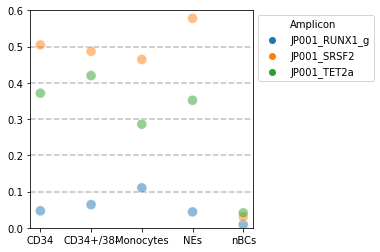

In [312]:
fig, ax = plt.subplots(figsize = (4,4))
sns.scatterplot(x = 'sort_celltype', y = 'VAF', data = x, s = 100,  hue = 'Amplicon', alpha = 0.5, ax = ax)
ax.legend(loc = 'upper left', bbox_to_anchor = [1,1])
ax.set_ylim(0,0.6)
ax.axhline(0.1, ls = '--', c = 'silver', zorder = 0)
ax.axhline(0.2, ls = '--', c = 'silver', zorder = 0)
ax.axhline(0.3, ls = '--', c = 'silver', zorder = 0)
ax.axhline(0.4, ls = '--', c = 'silver', zorder = 0)
ax.axhline(0.5, ls = '--', c = 'silver', zorder = 0)
ax.set_ylabel('')
ax.set_xlabel('')

In [313]:
plate3

JP001_RUNX1_g  JP001_SRSF2  JP001_TET2a Sort_cell_type  Plate_Well
AS-194 A12              0            0            0           nBCs  AS-194_A12
       A13              0            0            0           nBCs  AS-194_A13
       A16              0            0            0           nBCs  AS-194_A16
       A18              0            0            0           nBCs  AS-194_A18
       A19              0            0            0           nBCs  AS-194_A19
...                   ...          ...          ...            ...         ...
AS-187 H24              1            1            1      Monocytes  AS-187_H24
       I8               0            1            1      Monocytes   AS-187_I8
       I14              0            1            0      Monocytes  AS-187_I14
       L13              0            1            1      Monocytes  AS-187_L13
       P23              1            0            0      Monocytes  AS-187_P23

[1234 rows x 5 columns]

In [314]:
gby = plate3.groupby(by = ['Sort_cell_type'])
gby.get_group('NEs')

JP001_RUNX1_g  JP001_SRSF2  JP001_TET2a Sort_cell_type  Plate_Well
AS-195 B22              0            1            1            NEs  AS-195_B22
       C17              0            0            0            NEs  AS-195_C17
       D21              0            0            1            NEs  AS-195_D21
       G4               1            1            1            NEs   AS-195_G4
       G6               1            1            1            NEs   AS-195_G6
       G9               0            1            0            NEs   AS-195_G9
       G16              1            0            1            NEs  AS-195_G16
       G18              1            1            0            NEs  AS-195_G18
       G22              1            1            1            NEs  AS-195_G22
       H14              0            1            0            NEs  AS-195_H14
       I4               0            1            1            NEs   AS-195_I4
       I6               0            1            1            NEs   AS-195_I6
       I8               0            1            1            NEs   AS-195_I8
       I9               0            1            1            NEs   AS-195_I9
       I16              0            1            1            NEs  AS-195_I16
       I17              0            1            1            NEs  AS-195_I17
       I18              0            1            1            NEs  AS-195_I18
       I20              1            1            1            NEs  AS-195_I20
       I22              0            1            0            NEs  AS-195_I22
       I24              0            1            0            NEs  AS-195_I24
       J6               0            1            1            NEs   AS-195_J6
       L16              0            0            1            NEs  AS-195_L16
       M3               1            0            1            NEs   AS-195_M3
       M21              0            0            1            NEs  AS-195_M21
       O17              0            1            1            NEs  AS-195_O17
       O22              0            0            1            NEs  AS-195_O22
       P18              0            0            0            NEs  AS-195_P18
AS-189 C2               0            1            1            NEs   AS-189_C2
       C17              0            0            1            NEs  AS-189_C17
       D9               0            1            1            NEs   AS-189_D9
       E2               0            0            1            NEs   AS-189_E2
       N3               0            1            1            NEs   AS-189_N3

In [315]:
len(plate3['JP001_RUNX1_g'])

1234

In [316]:
#cols = ['JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a','JP001_TET2b_g']
cols = ['JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a']
cells = plate3['Sort_cell_type'].drop_duplicates().to_list()
heads = ['Sort_cell_type', 'Amplicon', 'n_mut', 'vaf', 'total']
data = pd.DataFrame(columns = heads)
for c in cells:
    df = plate3.loc[plate3['Sort_cell_type'].isin([c])]
    data2 = {}
    for co in cols:
        tot = len(df[co])
        n_mut = df[co].sum()     
        vaf = n_mut/tot
        sers = [c, co, n_mut, vaf, tot]
        df2 = pd.Series(data=sers, index = heads)
        data = data.append(df2, ignore_index = True)
        
data.sort_values(by=['Sort_cell_type'], inplace = True)
data

,Sort_cell_type,Amplicon,n_mut,vaf,total
3,CD34,JP001_RUNX1_g,33,0.072052,458
4,CD34,JP001_SRSF2,456,0.995633,458
5,CD34,JP001_TET2a,384,0.838428,458
6,CD34+/38-,JP001_RUNX1_g,9,0.115385,78
7,CD34+/38-,JP001_SRSF2,73,0.935897,78
8,CD34+/38-,JP001_TET2a,63,0.807692,78
9,Monocytes,JP001_RUNX1_g,79,0.376190,210
10,Monocytes,JP001_SRSF2,189,0.900000,210
11,Monocytes,JP001_TET2a,162,0.771429,210
12,NEs,JP001_RUNX1_g,7,0.218750,32


Text(0.5, 0, '')

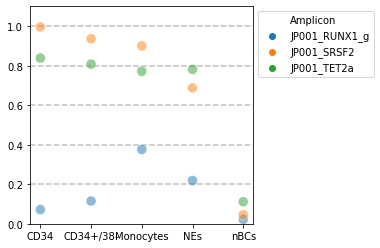

In [317]:
fig, ax = plt.subplots(figsize = (4,4))
sns.scatterplot(x = 'Sort_cell_type', y = 'vaf', data = data, s = 100,  hue = 'Amplicon', alpha = 0.5, ax = ax)
ax.legend(loc = 'upper left', bbox_to_anchor = [1,1])
ax.set_ylim(0,1.1)
#ax.axhline(0.1, ls = '--', c = 'silver', zorder = 0)
ax.axhline(0.2, ls = '--', c = 'silver', zorder = 0)
#ax.axhline(0.3, ls = '--', c = 'silver', zorder = 0)
ax.axhline(0.4, ls = '--', c = 'silver', zorder = 0)
#ax.axhline(0.5, ls = '--', c = 'silver', zorder = 0)
ax.axhline(0.6, ls = '--', c = 'silver', zorder = 0)
#ax.axhline(0.7, ls = '--', c = 'silver', zorder = 0)
ax.axhline(0.8, ls = '--', c = 'silver', zorder = 0)
#ax.axhline(0.9, ls = '--', c = 'silver', zorder = 0)
ax.axhline(1.0, ls = '--', c = 'silver', zorder = 0)
ax.set_ylabel('')
ax.set_xlabel('')

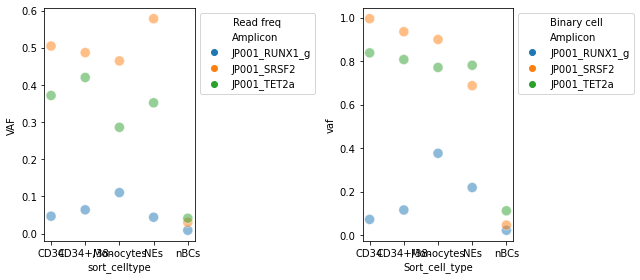

In [320]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9,4))
sns.scatterplot(x = 'sort_celltype', y = 'VAF', data = x, s = 100,  hue = 'Amplicon', alpha = 0.5, ax = ax1)
sns.scatterplot(x = 'Sort_cell_type', y = 'vaf', data = data, s = 100,  hue = 'Amplicon', alpha = 0.5, ax = ax2)
ax1.legend(loc = 'upper left', bbox_to_anchor = [1,1], title = 'Read freq')
ax2.legend(loc = 'upper left', bbox_to_anchor = [1,1], title = 'Binary cell')
fig.tight_layout()